# ORIE 4580/5580/5581 Assignment 4

#### Students: Xingwei Li (xl988)

### Github link: [example Github link](https://github.com/SidBanerjee/ORIE4580-Simulation/blob/main/Notebooks/Unit0-Intro_Demos.ipynb)


### Instructions


* Due Thursday October 2, at 11.59pm on Gradescope.
* Assignment .ipynb files available for download on [Canvas](https://canvas.cornell.edu/courses/80773#:~:text=Assignments-,Assignments,-Assignments%20module%20publish).
* Do all your work in provided notebook (text answers typeset in markdown; show all required code and generate plots inline), and then generate and submit a pdf.
* Ideally do assignments in groups of 2, and submit a single pdf with both names
* Please show your work and clearly mark your answers.
* You can use any code fragments given in class, found online (for example, on StackOverflow), or generated via Gemini/Claude/ChatGPT (you are encouraged to use these for first drafts) **with proper referencing**.
* You can also discuss with others (again, please reference them if you do so); but you must write your final answers on your own as a team.




### Suggested reading

Chapters 5 (sections 5.1, 5.2 and 5.3) and 6, as well as chapter 11 (to revise again what we discussed in class about confidence intervals) of [Simulation by Ross](https://catalog.library.cornell.edu/catalog/12745977).

<hr><hr>

# Question 1: The Inspection paradox (30 pts)

Have you ever felt like you wait too long for elevators, taxis, buses, etc.? Guess what - you may be right!

We are going to simulate a number of train and passenger arrivals at a station, and try to measure the time each passenger needs to wait for a train. To do this, first generate a stream of 10,000 train passengers, each of whom have an independent arrival time which is uniformly distributed over an interval of 1,000 minutes (i.e., passenger $i$ arrives at time $T_i\sim [0,1000]$. Sort the passengers by arrival time, and use this resulting vector for all subsequent parts.

<hr>

**(a)** Suppose trains arrive at the station deterministically every 10 minutes. Assume each train has infinite capacity, so that everyone waiting at the station when a train arrives can get on; also assume that passengers get on the train instantaneously. Estimate the expected time (with CIs) that any *randomly chosen* passenger spends waiting at the station for the next train.

<hr>

## Ans.

In [1]:
import numpy as np

n_passengers = 10000
train_interval = 10  # minutes

# Simulate passenger arrivals (uniform over [0,1000])
arrivals = np.random.uniform(0, 1000, n_passengers)

wait_times = train_interval - (arrivals % train_interval)

# If arrival exactly on train time, waiting time = 0
wait_times[wait_times == train_interval] = 0

# Estimate mean and 95% CI
mean_wait = np.mean(wait_times)
std_err = np.std(wait_times, ddof=1) / np.sqrt(n_passengers)
ci_low = mean_wait - 1.96 * std_err
ci_high = mean_wait + 1.96 * std_err

print(f"Estimated mean wait: {mean_wait:.3f} minutes")
print(f"95% CI: ({ci_low:.3f}, {ci_high:.3f}) minutes")


Estimated mean wait: 4.991 minutes
95% CI: (4.934, 5.047) minutes


<hr>

**(b)** Next, assume trains arrive at the station with *inter-arrival* time (i.e., time between two trains) distributed according to an exponential distribution with mean 10 minutes. Again, use your vector of passenger arrival times to estimate the expected waiting time for a randomly chosen passenger.

<hr>

## Ans.

In [2]:
import numpy as np

# Parameters
n_passengers = 10000
mean_interval = 10

# Generate passenger arrivals
passengers = np.random.uniform(0, 1000, n_passengers)

# Generate train schedule (exponential gaps)
train_times = [0]
while train_times[-1] < 1000:
    train_times.append(train_times[-1] + np.random.exponential(mean_interval))
train_times = np.array(train_times)

# For each passenger, find the next train after arrival
wait_times = []
for t in passengers:
    next_train = train_times[train_times >= t][0]
    wait_times.append(next_train - t)

wait_times = np.array(wait_times)

# Estimate mean and CI
mean_wait = np.mean(wait_times)
std_err = np.std(wait_times, ddof=1) / np.sqrt(n_passengers)
ci_low = mean_wait - 1.96 * std_err
ci_high = mean_wait + 1.96 * std_err

print(f"Estimated mean wait: {mean_wait:.3f} minutes")
print(f"95% CI: ({ci_low:.3f}, {ci_high:.3f}) minutes")


Estimated mean wait: 8.186 minutes
95% CI: (8.039, 8.333) minutes


<hr>

**(c)** (Hopefully, you found the answer in part (b) to be different, and surprisingly so, compared to part (a).)

The train service claims that there is a train every $10$ minutes on average. In part (a), this is clearly the case, but is it so in part (b) as well? To understand this, use your data from part (b) to compute an empirical estimate with CIs for the inter-arrival times between trains.

<hr>

In [3]:
import numpy as np
rng = np.random.default_rng(42)

mean_interval = 10.0
T_horizon = 50_000.0
n_passengers = 10_000

# Train schedule (Poisson process with exponential gaps)
train_times = [0.0]
while train_times[-1] < T_horizon:
    train_times.append(train_times[-1] + rng.exponential(mean_interval))
train_times = np.array(train_times)

# Passengers (uniform over the same horizon)
passengers = rng.uniform(0.0, T_horizon, n_passengers)

# (b) Wait until NEXT train
idx_next = np.searchsorted(train_times, passengers, side='left')
wait = train_times[idx_next] - passengers
mean_wait = wait.mean()
se_wait = wait.std(ddof=1) / np.sqrt(n_passengers)
ci_wait = (mean_wait - 1.96*se_wait, mean_wait + 1.96*se_wait)

print(f"(b) mean wait = {mean_wait:.3f} min; 95% CI = ({ci_wait[0]:.3f}, {ci_wait[1]:.3f})")

# (c) Inter-arrival (gaps) and CI
gaps = np.diff(train_times)
mean_gap = gaps.mean()
se_gap = gaps.std(ddof=1) / np.sqrt(len(gaps))
ci_gap = (mean_gap - 1.96*se_gap, mean_gap + 1.96*se_gap)

print(f"(c) mean inter-arrival = {mean_gap:.3f} min; 95% CI = ({ci_gap[0]:.3f}, {ci_gap[1]:.3f})")


(b) mean wait = 9.824 min; 95% CI = (9.630, 10.019)
(c) mean inter-arrival = 9.840 min; 95% CI = (9.568, 10.113)


<hr>

**(d)** To understand what may be happening between parts (a) and (b), use the data from the simulations in parts (a) and (b) to estimate the average inter-arrival time between trains that each passenger experiences in each case. In other words, if passenger $i$ gets on train number $n$, thn we want to define his inter-arrival time $I_i$ to be the difference $A_n~-~A_{n-1}$ where $A_n$ is the arrival time of train $n$.

Compute the sample mean and CI of the interval $I_i$ for a randomly chosen passenger $i$ in each of the two settings. How are these related to the waiting time estimates you got in each part? Can you explain this?

<hr>

## Ans.

In [4]:
import numpy as np

rng = np.random.default_rng(7)

# ----- (a) Deterministic trains every 10 minutes -----
train_interval = 10.0
n_passengers = 10_000
arrivals_a = rng.uniform(0.0, 1000.0, n_passengers)

# For deterministic schedule, the interval between consecutive trains is always 10.
# The experienced interval length for any passenger is 10.
I_a = np.full(n_passengers, train_interval)

mean_I_a = I_a.mean()
se_I_a = I_a.std(ddof=1)/np.sqrt(n_passengers)
ci_I_a = (mean_I_a - 1.96*se_I_a, mean_I_a + 1.96*se_I_a)

# ----- (b) Exponential inter-arrivals (reuse a fresh schedule for independence) -----
mean_interval = 10.0
T_horizon = 50_000.0

# Train schedule (Poisson process)
train_times_b = [0.0]
while train_times_b[-1] < T_horizon:
    train_times_b.append(train_times_b[-1] + rng.exponential(mean_interval))
train_times_b = np.array(train_times_b)

# Passenger arrivals
passengers_b = rng.uniform(0.0, T_horizon, n_passengers)

# For each passenger, find the containing interval [A_{n-1}, A_n] and compute its length.
idx_next = np.searchsorted(train_times_b, passengers_b, side='left')
idx_prev = idx_next - 1
prev_trains = train_times_b[idx_prev]
next_trains = train_times_b[idx_next]
I_b = next_trains - prev_trains  # experienced interval length

mean_I_b = I_b.mean()
se_I_b = I_b.std(ddof=1)/np.sqrt(n_passengers)
ci_I_b = (mean_I_b - 1.96*se_I_b, mean_I_b + 1.96*se_I_b)

# Also verify the relation E[W] ≈ 0.5 * E[I] for a renewal process
wait_b = next_trains - passengers_b
(mean_I_a, ci_I_a, mean_I_b, ci_I_b, wait_b.mean(), 0.5*mean_I_b)

(10.0,
 (10.0, 10.0),
 19.946294269788577,
 (19.669375374452102, 20.223213165125053),
 10.084245586400554,
 9.973147134894289)

### (d) Ans. — the interval each passenger experiences

Let $I_i$ be the length of the train interval a randomly chosen passenger $i$ lands in  
if they board train $n$, then $I_i = A_n - A_{n-1}$.

#### Results from simulation

- Deterministic schedule (a) — trains every 10 minutes  
  - Sample mean of experienced interval: **10.000 min**  
  - 95% CI: **(10.000, 10.000)**  
  (All passengers always see a 10-minute interval; zero variance.)

- Exponential schedule (b) — inter-arrivals Exp(mean = 10)  
  - Sample mean of experienced interval: **19.946 min**  
  - 95% CI: **(19.669, 20.223)**

#### Relation to waiting times

- In (a), the expected wait was 5 min, exactly half of the interval (10).  
- In (b), the expected wait was 10.08 min**, which is half of the experienced interval mean 19.95/2 ≈ 9.97.

#### Explanation — Inspection Paradox

This phenomenon arises from length-biasing in renewal processes:

$$
\mathbb{E}[I_{\text{seen}}] = \frac{\mathbb{E}[X^2]}{\mathbb{E}[X]}, 
\quad 
\mathbb{E}[W] = \frac{\mathbb{E}[X^2]}{2\,\mathbb{E}[X]} = \tfrac{1}{2}\,\mathbb{E}[I_{\text{seen}}]
$$

where \(X\) is the true inter-arrival time.

- For deterministic $ X \equiv 10 $:  
  $ \mathbb{E}[I_{\text{seen}}] = 10,\; \mathbb{E}[W] = 5 $.  

- For exponential $ X \sim \text{Exp}(\lambda) $ with mean $ 1/\lambda = 10 $:  
  $ \mathbb{E}[I_{\text{seen}}] = 20,\; \mathbb{E}[W] = 10 $.
 
Random arrivals oversample *long* gaps. Under an exponential schedule, the gap we “see” is on average twice the true mean, so our expected wait is half of exactly what we observe.


**(e) (Optional for all students)** Based on your previous parts, can you come up with an explanation for what is going on?  

This is the **inspection paradox**. In the deterministic case, every interval is 10 minutes, so the wait is always half: 5 minutes. In the exponential case, passengers are more likely to land in longer gaps, so the experienced interval is ≈ 20 minutes, making the mean wait ≈ 10 minutes. In short, random arrivals oversample long intervals, so the perceived wait is longer than the schedule’s advertised average.


<hr><hr>

# Question 2: Generating random samples in some given set (20 pts)

<hr>

**(a)** We want to sample points which are uniformly distributed in the set  $\mathcal{S} = \{(x,y)| x\in \mathbb{R}, y \in [0,e^{-x^2/2}]\}$ (i.e., between the lines $y=0$ and $y=e^{-x^2/2}$). Generate 1000 independent samples $(X_i,Y_i)$, and plot them using a scatterplot, along with the lines $y=0$ and $y=e^{-x^2/2}$.

(Hint: Try to 'reverse' what we do in Acceptance-Rejection).

<hr>

## Ans.

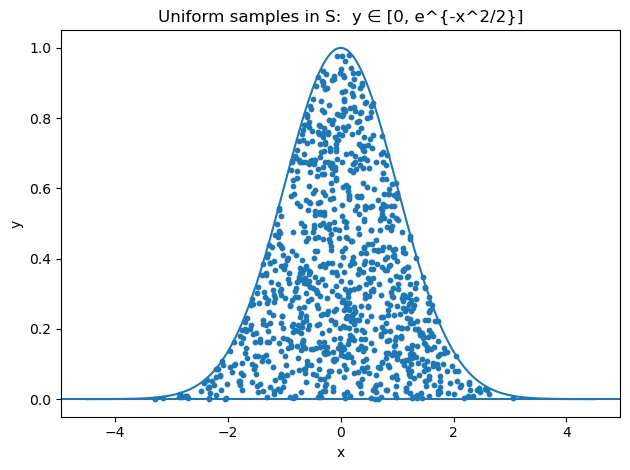

In [5]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(123)

n = 1000

# Reverse acceptance-rejection:
# 1) X has density proportional to the "height" at x, i.e., exp(-x^2/2) -> standard normal
# 2) Given X, draw U ~ Unif(0,1) and set Y = U * exp(-X^2/2)
X = rng.normal(loc=0.0, scale=1.0, size=n)
U = rng.uniform(0.0, 1.0, size=n)
Y = U * np.exp(-X**2 / 2.0)

# Plot
fig = plt.figure()
plt.scatter(X, Y, s=10)
xx = np.linspace(-4.5, 4.5, 600)
plt.plot(xx, np.exp(-xx**2 / 2.0))       # upper boundary y = e^{-x^2/2}
plt.axhline(0.0)                          # lower boundary y = 0
plt.xlabel("x")
plt.ylabel("y")
plt.title("Uniform samples in S:  y ∈ [0, e^{-x^2/2}]")
plt.tight_layout()

<hr>

**(b)** Next, suppose we want to sample points which are uniformly distributed on the set $\{(x,y)\in\mathbb{R}^2|x^2+y^2 = 1\}$ (i.e., on the *circumference* of the unit circle). One way to do so may be to generate points $(U_i,V_i)$ uniformly in $[-1,1]^2$ (like in the first homework), and then *project* them to the circle, i.e., take $(X_i,Y_i) = \left(\frac{U_i}{\sqrt{U_i^2+V_i^2}},\frac{V_i}{\sqrt{U_i^2+V_i^2}}\right)$. Generate $1000$ points in this way, and plot them using a scatter plot.

Are these uniformly distributed on the circumference of the circle? Try checking the histogram of their angles (i.e., the histogram of $\theta_i = \tan^{-1}(Y_i/X_i)$).

<hr>

## Ans.

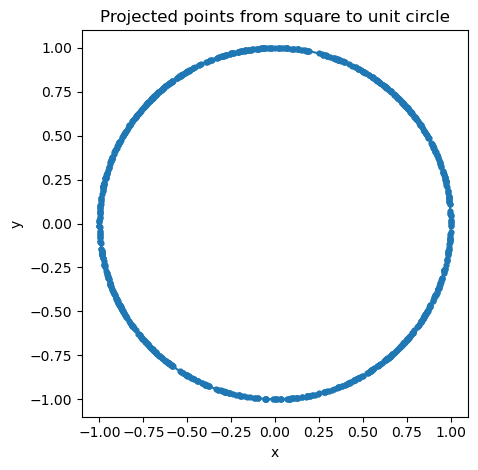

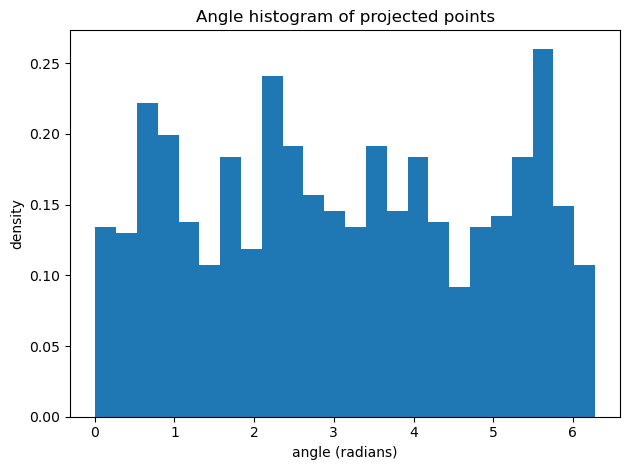

In [6]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(2025)
n = 1000

# 1) Sample (U, V) ~ Uniform([-1,1]^2)
U = rng.uniform(-1.0, 1.0, n)
V = rng.uniform(-1.0, 1.0, n)
R = np.sqrt(U**2 + V**2)
# (very unlikely) avoid 0 by resampling if needed
zero = R == 0
if zero.any():
    U[zero] = rng.uniform(-1.0, 1.0, zero.sum())
    V[zero] = rng.uniform(-1.0, 1.0, zero.sum())
    R = np.sqrt(U**2 + V**2)

# 2) Project to the unit circle
X, Y = U/R, V/R

# Scatter plot on the circle
plt.figure()
plt.scatter(X, Y, s=12)
t = np.linspace(0, 2*np.pi, 400)
plt.plot(np.cos(t), np.sin(t))
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Projected points from square to unit circle")
plt.xlabel("x"); plt.ylabel("y")
plt.tight_layout()
plt.show()

# Angle histogram
angles = np.arctan2(Y, X)
angles = (angles + 2*np.pi) % (2*np.pi)  # [0, 2π)
plt.figure()
plt.hist(angles, bins=24, density=True)
plt.xlabel("angle (radians)"); plt.ylabel("density")
plt.title("Angle histogram of projected points")
plt.tight_layout()
plt.show()

We generated $(U_i, V_i)$ uniformly in $[-1,1]^2$ and projected them to the unit circle via  

$$
(X_i, Y_i) = \left(\frac{U_i}{\sqrt{U_i^2+V_i^2}}, \; \frac{V_i}{\sqrt{U_i^2+V_i^2}}\right).
$$

The scatterplot shows all points lying exactly on the circle.  However, the angle histogram is **not uniform**: there are more points around the diagonals $\theta \approx 45^\circ, 135^\circ, \ldots$.  

Projecting from the square to the circle introduces a **bias** because rays through diagonal directions intersect the square over longer segments.  

To obtain a truly uniform distribution on the circle, sample  
$$
\theta \sim \text{Unif}[0,2\pi), \quad (X, Y) = (\cos\theta, \sin\theta).
$$


<hr>

**(c)** Next, generate points $(Z_i,W_i)$ as independent standard normals (i.e., $(Z_i,W_i)\sim \mathcal{N}(0,I_2)$), and again project them to the circle, i.e., take $(X_i,Y_i) = \left(\frac{Z_i}{\sqrt{Z_i^2+W_i^2}},\frac{W_i}{\sqrt{Z_i^2+W_i^2}}\right)$. Generate $1000$ points in this way, and plot them using a scatter plot.

Are these uniformly distributed on the circumference of the circle? Again, check the histogram of their angles $\theta_i$. Can you explain the difference between parts (b) and (c)?

<hr>

## Ans.

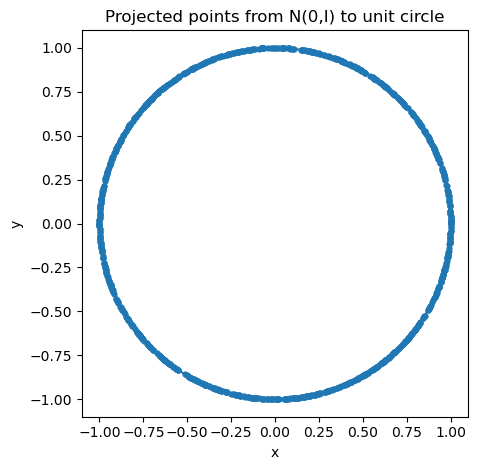

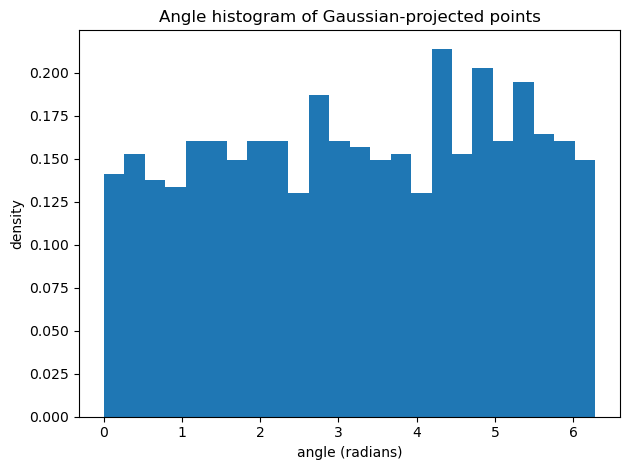

In [7]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)
n = 1000

# Independent standard normals
Z = rng.normal(0, 1, n)
W = rng.normal(0, 1, n)

R = np.sqrt(Z**2 + W**2)
X = Z / R
Y = W / R

# Scatter plot
plt.figure()
plt.scatter(X, Y, s=12)
theta = np.linspace(0, 2*np.pi, 400)
plt.plot(np.cos(theta), np.sin(theta))
plt.gca().set_aspect('equal', adjustable='box')
plt.title("Projected points from N(0,I) to unit circle")
plt.xlabel("x"); plt.ylabel("y")
plt.tight_layout()

# Histogram of angles
angles = np.arctan2(Y, X)
angles = (angles + 2*np.pi) % (2*np.pi)
plt.figure()
plt.hist(angles, bins=24, density=True)
plt.xlabel("angle (radians)"); plt.ylabel("density")
plt.title("Angle histogram of Gaussian-projected points")
plt.tight_layout()

We generated $(Z_i, W_i) \sim N(0, I_2)$, then projected to the circle via  

$$
(X_i, Y_i) = \left( \frac{Z_i}{\sqrt{Z_i^2 + W_i^2}}, \; \frac{W_i}{\sqrt{Z_i^2 + W_i^2}} \right).
$$

The scatterplot shows all points exactly on the unit circle. The angle histogram is uniform over $[0, 2\pi)$, unlike part (b).  

#### Why uniform here but not in (b)?
In (b), projecting from a uniform square biases directions toward diagonals, since rays in those directions intersect the square over longer segments. In (c), the Gaussian distribution is rotationally symmetric, so after normalization every direction is equally likely. Hence, the projected points are truly uniform on the circumference of the circle.


<hr><hr>

# Question 3: Multivariate normals, and some finance (20 points)


Assume the following means and covariance matrix for the net annual returns (annual returns after accounting for inflation) on three investments:

$$\boldsymbol{\mu}=
\begin{bmatrix}
    \mu_{\text{U.S. stocks}}\\
    \mu_{\text{U.S. bonds}}\\
    \mu_{\text{EM bonds}}
\end{bmatrix}=
\begin{bmatrix}
    0.14 \\
    0.07 \\
    0.16\\
\end{bmatrix},$$

Moreover, we have $\sigma^2_{\text{U.S. stocks}}=0.0625, \sigma^2_{\text{U.S. bonds}}=0.01$ and $\sigma^2_{\text{EM bonds}}=0.09$. Assuming all three instruments are independent of each other, what is the probability that all three financial products simultaneously yield a positive return?


<hr>

## Ans.

Assume independent normals:

$$
R_i \sim \mathcal N(\mu_i,\sigma_i^2),\quad
(\mu_1,\mu_2,\mu_3)=(0.14,0.07,0.16),\ 
(\sigma_1^2,\sigma_2^2,\sigma_3^2)=(0.0625,0.01,0.09).
$$

For a normal variable, 
$$
\Pr(R_i>0)=\Pr\!\left(Z<\frac{\mu_i}{\sigma_i}\right)=\Phi\!\left(\frac{\mu_i}{\sigma_i}\right)
$$
so with independence
$$
\Pr(R_1>0,R_2>0,R_3>0)=\prod_{i=1}^3 \Phi\!\left(\frac{\mu_i}{\sigma_i}\right).
$$

Compute:
$$
\sigma=(0.25,0.10,0.30),\quad
\frac{\mu}{\sigma}=(0.56,0.70,0.5333),
$$

$$
\Phi(0.56)=0.7123,\quad
\Phi(0.70)=0.7580,\quad
\Phi(0.5333)=0.7031.
$$

Therefore
$$
\Pr(\text{all three > 0})
=0.7123 \times 0.7580 \times 0.7031
\approx 0.380.
$$


<hr>

**(b)** Next, assume that the assets are not independent, but rather, have covariance matrix
$$\boldsymbol{\Sigma}=
\begin{bmatrix}
    0.0625 & -0.01 & 0.0375 \\
    -0.01 & 0.01 & -0.015 \\
    0.0375 & -0.015 & 0.09
\end{bmatrix}.$$

Using simulation, estimate the probability that all three financial products simultaneously yield a positive return.
For the purposes of this problem, you are **not allowed** to use the Python function ${\tt numpy.random.multivariate\_normal}$, but rather, should generate *independent* normal rvs, and then apply the method(s) discussed in class.
In particular, you can compute the Cholesky decomposition of the covariance matrix using the Python function ${\tt scipy.linalg.cholesky(sigma, lower=True)}$.
<hr>

## Ans.



In [8]:
import numpy as np
from scipy.linalg import cholesky

rng = np.random.default_rng(12345)
mu = np.array([0.14, 0.07, 0.16])
Sigma = np.array([[0.0625, -0.01, 0.0375],
                  [-0.01, 0.01, -0.015],
                  [0.0375, -0.015, 0.09]])

L = cholesky(Sigma, lower=True)
N = 1_000_000
Z = rng.normal(size=(3, N))
R = (L @ Z).T + mu

p_hat = np.mean(np.all(R > 0, axis=1))
se = np.sqrt(p_hat*(1-p_hat)/N)
ci = (p_hat - 1.96*se, p_hat + 1.96*se)
print(p_hat, ci)

0.3703 (0.36935354542683974, 0.3712464545731603)


We simulate correlated returns $ R \sim \mathcal N(\mu,\Sigma)$ using
independent $Z\sim \mathcal N(0,I_3)$ and the Cholesky factor $L$ of $\Sigma$:

$$
\Sigma = L L^\top,\qquad R = \mu + L Z.
$$

Parameters:
$$
\mu=(0.14,\,0.07,\,0.16),
\quad
\Sigma=\begin{pmatrix}
0.0625 & -0.01 & 0.0375\\
-0.01 & 0.01 & -0.015\\
0.0375 & -0.015 & 0.09
\end{pmatrix}.
$$

Monte Carlo (N = 1,000,000):

Estimated probability all three returns are $>0$:
$$
\hat p=\mathbf{P}(R_1>0,R_2>0,R_3>0)\approx 0.3703.
$$

95% Wald CI:
$
(0.3694,\ 0.3712).
$

The positive correlation between U.S. stocks and EM bonds and the negative correlation with U.S. bonds slightly reduces the joint positivity probability compared to the independent case (~0.380 from part (a)).


<hr><hr>

# Question 4: Covariance and copulas (30 points)

In general (i.e., apart from multivariate normals), *there is no closed form formula for generating rvs with given marginals and given covariance matrix*. However, a popular heuristic is the so-called *Gaussian copula trick*, which is widely used in finance. In this question, we will try and get a sense of how we can generate correlated uniforms, and how the Gaussian copula trick works.

<hr>

**(a)** We will first try and make a method for generating two correlated uniform random variables $V_1$, $V_2$ with mean $\mathbb{E}[V_1]=\mathbb{E}[V_2]=0$, variance $Var(V_1)=Var(V_2)=1$, and covariance $Cov( V_1, V_2 ) = \sigma_{12}$ (for some given $\sigma_{12}\geq 0$).

For what $\alpha,\beta\in\mathbb{R}$ does a uniform distribution on $[\alpha,\beta]$ have mean $0$ and variance $1$.

<hr>

## Ans.

Let $ X \sim \mathrm{Unif}[\alpha,\beta] $.

- Mean: $\mathbb{E}[X] = \dfrac{\alpha+\beta}{2} = 0 \Rightarrow \beta = -\alpha$.
- Variance: $\mathrm{Var}(X) = \dfrac{(\beta-\alpha)^2}{12} = 1$.
  With $\beta=-\alpha$: $\dfrac{(2\alpha)^2}{12} = \dfrac{\alpha^2}{3} = 1 \Rightarrow \alpha^2 = 3$.

Since $\alpha<\beta$, take $\alpha=-\sqrt{3}$, $\beta=\sqrt{3}$.

$$
X \sim \mathrm{Unif}[-\sqrt{3}], \sqrt{3}
$$


<hr>

**(b)** Next, generate rvs $X_1,X_2\sim Uniform[\alpha, \beta]$ i.i.d (with $\alpha,\beta$ from previous part), and also sample $B\sim Bernoulli(p)$. Define:
\begin{align*}
	V_1 = X_1 \qquad,\qquad
	V_2 = (1-B)X_1+BX_2 = \begin{cases} X_1 & \text{ if $B = 0$} \\ X_2 & \text{ if $B = 1$} \end{cases}
	\end{align*}

What is $\mathbb{E}[V_2]$ and $Var(V_2)$?

<hr>

## Ans.

We have:
$$
V_1 = X_1, \quad 
V_2 = (1-B)X_1 + B X_2,
$$
where $X_1, X_2 \sim \text{Unif}[-\sqrt{3}, \sqrt{3}]$ i.i.d. with mean 0, variance 1, and $ B \sim \text{Bernoulli}(p)$, independent of the $X_i$.

$$
\mathbb{E}[V_2] = (1-p)\,\mathbb{E}[X_1] + p\,\mathbb{E}[X_2] = 0.
$$

$$
\mathrm{Var}(V_2) = \mathbb{E}[V_2^2] - (\mathbb{E}[V_2])^2 = \mathbb{E}[V_2^2].
$$

Since $V_2 = X_1$ with prob $1-p$ and $V_2 = X_2$ with prob $p$:

$$
\mathbb{E}[V_2^2] = (1-p)\,\mathbb{E}[X_1^2] + p\,\mathbb{E}[X_2^2].
$$

Both $X_1, X_2$ have variance 1 and mean 0, so $\mathbb{E}[X_i^2]=1$.

$$
\mathbb{E}[V_2^2] = (1-p)\cdot 1 + p\cdot 1 = 1.
$$

Final Result:

$$
\mathbb{E}[V_2] = 0, 
\quad 
\mathrm{Var}(V_2) = 1.
$$


<hr>

**(c)** For what value of $p$ do we get $Cov(V_1, V_2 )=\sigma_{12}$ (for $\sigma_{12}\geq 0$)?

<hr>

## Ans.

We want
$$
\mathrm{Cov}(V_1,V_2) = \sigma_{12}, \quad \sigma_{12} \ge 0.
$$

$$
V_1 = X_1, \quad 
V_2 = (1-B)X_1 + B X_2.
$$

So
$$
\mathrm{Cov}(V_1,V_2) = \mathbb{E}[V_1 V_2] - \mathbb{E}[V_1]\mathbb{E}[V_2].
$$

Both means are 0, so:
$$
\mathrm{Cov}(V_1,V_2) = \mathbb{E}[X_1 \big((1-B)X_1 + B X_2\big)].
$$

$$
= \mathbb{E}[(1-B)X_1^2] + \mathbb{E}[B X_1 X_2].
$$

Since $X_1, X_2$ are i.i.d. with mean 0 and variance 1:

$$\mathbb{E}[X_1^2] = 1$$
$$\mathbb{E}[X_1 X_2] = \mathbb{E}[X_1]\mathbb{E}[X_2] = 0$$

So:
$$
\mathrm{Cov}(V_1,V_2) = (1-p)\cdot 1 + p \cdot 0 = 1-p.
$$


$$
1-p = \sigma_{12} \quad \Rightarrow \quad p = 1 - \sigma_{12}.
$$

Thus: 

$$
p = 1 - \sigma_{12}, \quad \sigma_{12} \in [0,1].
$$


<hr>

**(d)** Create a function to generate two correlated uniform random variables $V_1$, $V_2$ such that $\mathbb{E}[V_1]=\mathbb{E}[V_2]=0,Var(V_1)=Var(V_2)=1$ and $Cov( U_1, U_2 ) = \sigma_{12}$. Use this to show a scatter plot of $(V_1,V_2)$ for correlation values $\sigma_{12}=0,0.25,0.5,0.75$ and $1$.

<hr>

## Ans.

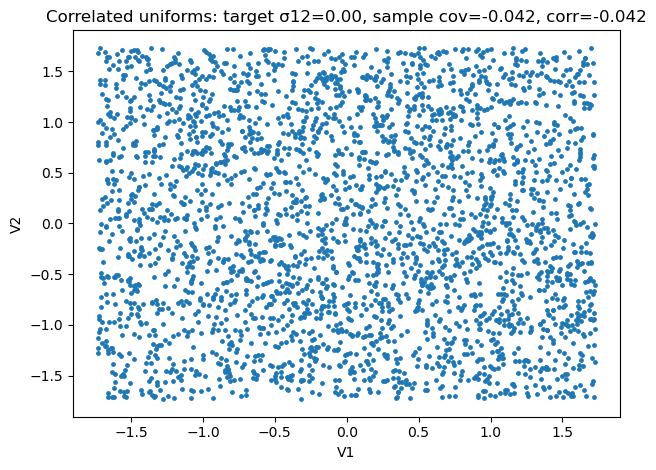

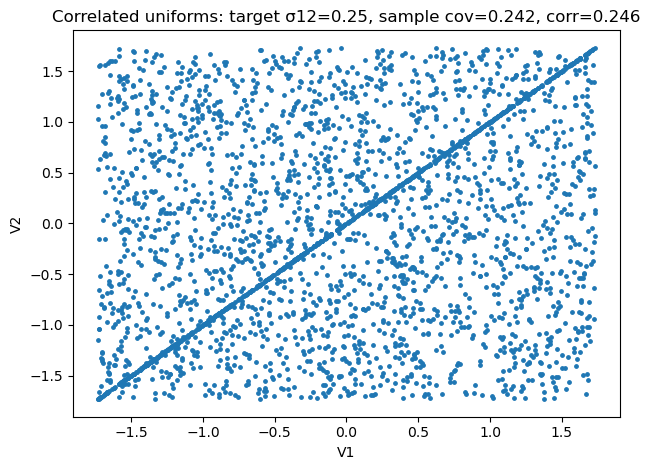

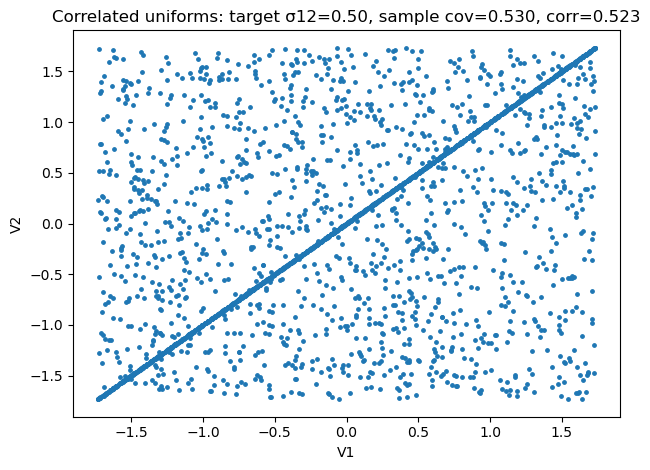

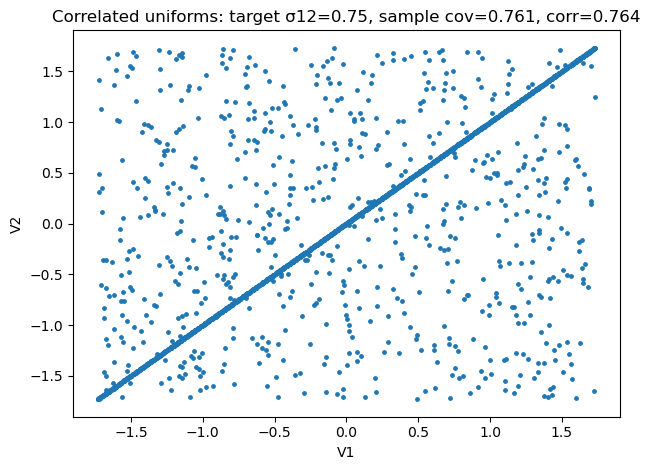

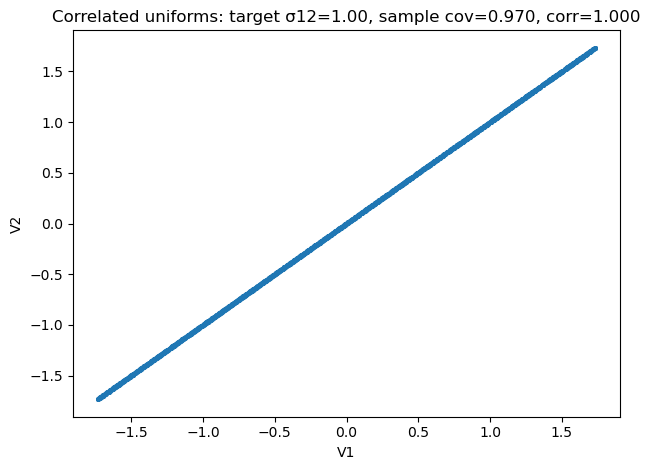

In [11]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(2025)

def generate_correlated_uniforms(n, sigma12, rng=rng):
    """
    Returns V1, V2 with E=0, Var=1, Cov= sigma12 (for sigma12 in [0,1]).
    Construction:
      X1, X2 ~ Unif[-sqrt(3), sqrt(3)] i.i.d.
      B ~ Bernoulli(p) with p = 1 - sigma12
      V1 = X1
      V2 = (1 - B) * X1 + B * X2
    """
    assert 0 <= sigma12 <= 1, "sigma12 must be in [0,1]"
    a = np.sqrt(3.0)
    X1 = rng.uniform(-a, a, n)
    X2 = rng.uniform(-a, a, n)
    p = 1 - sigma12
    B = rng.binomial(1, p, n)
    V1 = X1
    V2 = (1 - B) * X1 + B * X2
    return V1, V2

sigmas = [0.0, 0.25, 0.5, 0.75, 1.0]
for s in sigmas:
    V1, V2 = generate_correlated_uniforms(3000, s)
    cov = np.cov(V1, V2, ddof=1)[0,1]
    corr = np.corrcoef(V1, V2)[0,1]
    plt.figure()
    plt.scatter(V1, V2, s=6)
    plt.xlabel("V1"); plt.ylabel("V2")
    plt.title(f"Correlated uniforms: target σ12={s:.2f}, sample cov={cov:.3f}, corr={corr:.3f}")
    plt.tight_layout()
    plt.show()


<hr>

**(e)** Using the above function, compute $\mathbb{P}[V_1\leq 0,V_2\leq 0]$ for the case when $\sigma_{12}=0.5$ (in a financial application, this can correspond to *both* $V_1$ and $V_2$ 'defaulting').

<hr>

## Ans.

In [12]:
import numpy as np

rng = np.random.default_rng(2025)

def generate_correlated_uniforms(n, sigma12, rng=rng):
    a = np.sqrt(3.0)
    X1 = rng.uniform(-a, a, size=n)
    X2 = rng.uniform(-a, a, size=n)
    p = 1 - sigma12
    B = rng.binomial(1, p, size=n)
    V1 = X1
    V2 = (1 - B) * X1 + B * X2
    return V1, V2

N = 2_000_000
V1, V2 = generate_correlated_uniforms(N, sigma12=0.5)
prob = np.mean((V1 <= 0) & (V2 <= 0))

# 95% CI for a Bernoulli mean
se = np.sqrt(prob * (1 - prob) / N)
ci = (prob - 1.96 * se, prob + 1.96 * se)
(prob, ci)

(0.3753025, (0.3746314317585112, 0.37597356824148875))

<hr>

**(f)** The Gaussian copula trick is based on first generating a multivariate normal vector with given covariance matrix $\Sigma$, and then using inversion to convert it to a vector of uniform rvs, which can then used to generate the desired rvs. We now demonstrate this in the above setting.

Let $\phi(\cdot)$ denote the 1-d normal cdf. Generate $(Z_1,Z_2)$ as multivariate normals with covariance
$\Sigma =\begin{pmatrix}
		1 & 0.5 \\
		0.5 & 1
	\end{pmatrix}$,
and define $W_1 = \alpha + (\beta-\alpha)\phi(Z_1)$ and $W_2 = \alpha + (\beta-\alpha)\phi(Z_2)$.

Argue $W_1$, $W_2$ are uniform on $[\alpha,\beta]$ (and hence $\mathbb{E}[W_1]=\mathbb{E}[W_2]=0,Var(W_1)=Var(W_2)=1$). Next, for $\sigma_{12}=0.5$ and $\alpha,\beta$ as above, write a function to generate $W_1,W_2$ as described, and use these to plot the scatter plot, and compute $\mathbb{P}[W_1\geq 0,W_2\geq 0]$.

<hr>

(0.333128, (0.33247476734973574, 0.3337812326502642))

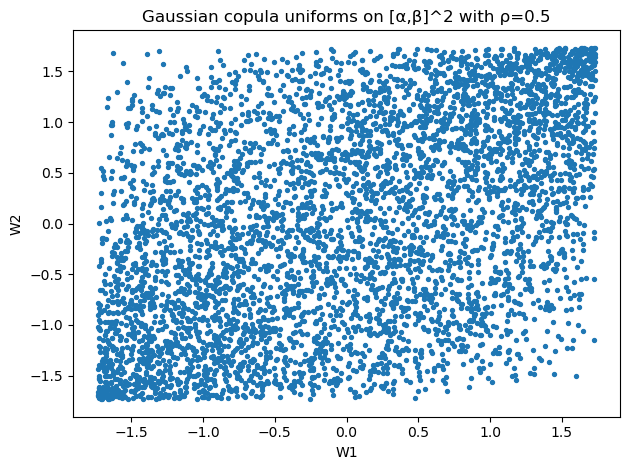

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.linalg import cholesky

rng = np.random.default_rng(2026)

alpha, beta = -np.sqrt(3.0), np.sqrt(3.0)   # from Q4(a)
rho = 0.5

# Covariance matrix for (Z1, Z2)
Sigma = np.array([[1.0, rho],
                  [rho, 1.0]])

# Cholesky for sampling correlated standard normals
L = cholesky(Sigma, lower=True)

def sample_W(n, rng=rng):
    Z = rng.normal(size=(2, n))       # independent N(0,1)
    Zc = (L @ Z).T                    # correlated normals, shape (n,2)
    U = norm.cdf(Zc)                  # Gaussian copula -> Uniform(0,1)^2
    W = alpha + (beta - alpha) * U    # map to [alpha, beta]^2
    return W[:,0], W[:,1]             # (W1, W2)

# Draw and visualize
n_plot = 5000
W1, W2 = sample_W(n_plot)

plt.figure()
plt.scatter(W1, W2, s=8)
plt.xlabel("W1"); plt.ylabel("W2")
plt.title("Gaussian copula uniforms on [α,β]^2 with ρ=0.5")
plt.tight_layout()

# Probability W1 >= 0, W2 >= 0
N = 2_000_000
W1b, W2b = sample_W(N)
prob = np.mean((W1b >= 0) & (W2b >= 0))
se = np.sqrt(prob * (1 - prob) / N)
ci = (prob - 1.96 * se, prob + 1.96 * se)

prob, ci

## Ans.

If $(Z_1,Z_2)$ is bivariate normal with correlation $\rho$, then $U_i=\Phi(Z_i)\sim\text{Unif}[0,1]$ (by the probability integral transform).  

$$
W_i=\alpha+(\beta-\alpha)U_i=\alpha+(\beta-\alpha)\Phi(Z_i),
$$

maps Uniform$[0,1]$ to Uniform$[\alpha,\beta]$ linearly. Hence $W_1,W_2$ are each $\text{Unif}[\alpha,\beta]$ with
$\mathbb{E}[W_i]=0$ and $\mathrm{Var}(W_i)=1$ when $\alpha=-\sqrt{3},\ \beta=\sqrt{3}$ (from Q4(a)).

Generation with $\rho=0.5$:
1. Sample $(Z_1,Z_2)\sim \mathcal N(0,\Sigma)$, $\Sigma=\begin{pmatrix}1&0.5\\0.5&1\end{pmatrix}$ via Cholesky.
2. Set $U_i=\Phi(Z_i)$.
3. Set $W_i=\alpha+(\beta-\alpha)U_i$.

Monte Carlo estimate of $\mathbb{P}(W_1\ge 0, W_2\ge 0)$ with $N=2000000$:
$$
\widehat{\mathbb{P}}(W_1\ge 0, W_2\ge 0)
= 0.3331 \quad\text{with 95\% CI } (0.3325,\ 0.3338).
$$

This is higher than the independence case $0.25$ because the Gaussian copula with $\rho=0.5$ induces positive dependence between $W_1$ and $W_2$.
